# Explain Image Classifier with LIMA & SHAP

### Importing Libraries


In [1]:
from lime import lime_image
import numpy as np
import tensorflow as tf
import keras
import os
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import shap
from keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix

# Functions

### This function will be used to convert the numerical labels into their corresponding class names 

In [2]:
def get_stringlabel(n):
    if(n == 0):
        return 'glioma_tumor'
    if(n == 1): 
        return 'meningioma_tumor'
    if(n == 2): 
        return 'no_tumor'
    if(n == 3):
        return 'pituitary_tumor'

### Method to explain predicted images with LIME

Source1: https://towardsdatascience.com/how-to-explain-image-classifiers-using-lime-e364097335b4

Source2: https://github.com/brooke57/BrainTumorImageClassification/blob/main/Exploring_the_Black_Box_with_Lime.ipynb

In [3]:
def genereate_explination_lime(exp, image, model, image_index, pred):

  explanation = exp.explain_instance(image,
                                         model.predict, 
                                         top_labels=4,
                                         hide_color=0,
                                         num_samples=1000)
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                       positive_only=False, num_features=20,
                                                       hide_rest=False)
  lime_graph = mark_boundaries(temp, mask)

  plt.subplot(1, 3, 1)
  plt.imshow(image)  
    
  plt.subplot(1, 3, 2)
  plt.imshow(lime_graph)


  plt.subplot(1, 3, 3)
  plt.imshow(explanation.segments)
  plt.tight_layout()
  plt.show()

  print(f'Correct Label: {get_stringlabel(y_test[image_index])}')
  print(f'Predicted Label: {get_stringlabel(pred[image_index])}')

### Method to explain predicted images with SHAP

In [4]:
def genereate_explination_shap(exp, index, pred): 
    shap_values = exp(X_test[index:index+1], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])
    shap.image_plot(shap_values)
    get_stringlabel(y_test[index])
    print(f'Correct Label: {get_stringlabel(y_test[index])}')
    print(f'Predicted Label: {get_stringlabel(pred[index])}')

### Function to get the correct classified images

Source: https://github.com/brooke57/BrainTumorImageClassification/blob/main/Exploring_the_Black_Box_with_Lime.ipynb

In [5]:
def get_correct_classified_imgs(pred):
    right = []
    for i in range(len(X_test)):
        if pred[i] == y_test[i]:
            right.append(i)
    return right

### Function to get the incorrect classified images

Source: https://github.com/brooke57/BrainTumorImageClassification/blob/main/Exploring_the_Black_Box_with_Lime.ipynb

In [6]:
def get_incorrect_classified_imgs(pred):
    wrong = []
    for i in range(len(X_test)):
        if pred[i] != y_test[i]:
            wrong.append(i)
    return wrong

### Function to get prediction for an image at specific index

In [7]:
def get_proba(model, index):
    return model.predict(X_test)[index]

### Method to evaluate the model
Source: https://stackoverflow.com/questions/39033880/plot-confusion-matrix-sklearn-with-multiple-labels
Orginal Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [8]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))

# Reading & Pre-processing Data

source: https://www.kaggle.com/code/amay09/brain-tumor-detection-using-cnn

### Let's read the images from the training and testing folder

In [9]:
X_train=[]
Y_train=[]
image_size=150
labels=['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']
for i in labels:
    folderPath = os.path.join('archive/Training',i)
    for j in os.listdir (folderPath):
        img=cv2.imread(os.path.join(folderPath,j))
        img=cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        Y_train.append(i)
for i in labels:
    folderPath = os.path.join('archive/Testing',i)
    for j in os.listdir(folderPath):
        img=cv2.imread(os.path.join(folderPath,j))
        img=cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        Y_train.append(i)
X_train=np.array(X_train)

### Data Shuffling

In [10]:
X_train,Y_train=shuffle(X_train,Y_train,random_state=101)

### Splitting tain and Test data 

In [11]:
X_train,X_test,y_train,y_test=train_test_split(X_train,Y_train,test_size=0.1,random_state=101)

### Let's see how many images do we have in X_train and X_test

In [12]:
len_X_train = len(X_train)
len_X_test = len(X_test)
print(f'X_train has {len(X_train)} images')
print(f'X_test has {len(X_test)} images')

X_train has 2937 images
X_test has 327 images


### Converting the elements in the y_train ans y_test to their corresponding indices numerical labels encoding

In [13]:
y_train_new=[]
for i in y_train:
    y_train_new.append(labels.index(i))
y_train=y_train_new

y_test_new=[]
for i in y_test:
    y_test_new.append(labels.index(i))
y_test=y_test_new

### Let's take a look at our y_train

In [14]:
print((y_train))

[0, 1, 1, 0, 3, 1, 3, 1, 1, 2, 2, 0, 3, 2, 1, 3, 1, 0, 1, 2, 1, 3, 3, 2, 0, 0, 0, 1, 2, 3, 3, 0, 3, 3, 1, 3, 1, 2, 2, 2, 2, 0, 3, 1, 2, 1, 0, 1, 3, 3, 2, 0, 1, 1, 1, 0, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 2, 3, 1, 3, 3, 1, 1, 1, 3, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 2, 2, 2, 1, 3, 2, 1, 1, 3, 1, 2, 3, 3, 0, 1, 0, 3, 1, 1, 1, 1, 0, 1, 0, 3, 1, 0, 0, 3, 2, 0, 2, 1, 0, 0, 3, 0, 3, 1, 3, 1, 3, 1, 1, 0, 1, 0, 2, 2, 3, 0, 1, 0, 1, 2, 0, 3, 0, 0, 1, 1, 3, 1, 2, 2, 3, 1, 1, 3, 2, 3, 1, 2, 3, 0, 0, 2, 1, 1, 3, 3, 3, 1, 3, 0, 3, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 2, 2, 1, 2, 3, 2, 1, 3, 3, 1, 3, 0, 1, 1, 0, 1, 2, 2, 3, 2, 2, 0, 3, 0, 0, 2, 2, 0, 0, 2, 0, 1, 3, 0, 1, 0, 3, 3, 3, 0, 1, 3, 0, 1, 1, 0, 2, 0, 1, 2, 2, 1, 0, 0, 0, 2, 3, 1, 3, 3, 3, 0, 0, 2, 2, 1, 3, 2, 1, 3, 1, 1, 2, 3, 0, 2, 1, 2, 0, 0, 1, 3, 3, 0, 1, 1, 1, 3, 3, 1, 3, 1, 3, 0, 0, 0, 3, 1, 2, 1, 2, 2, 3, 3, 3, 1, 0, 3, 1, 0, 1, 0, 1, 1, 1, 2, 3, 0, 3, 3, 3, 1, 0, 1, 3, 2, 3, 3, 1, 0, 1, 1, 3, 0, 2, 3, 1, 2, 1, 1, 2, 1, 3, 0, 3, 2, 0, 2, 1, 3, 0, 3, 

### Converting the data to numpy array and checking the shap

In [15]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print('X_train shape  is ', X_train.shape)
print('X_test shape  is ', X_test.shape)
print('y_train shape  is' , y_train.shape)
print('y_test shape  is', y_test.shape)

X_train shape  is  (2937, 150, 150, 3)
X_test shape  is  (327, 150, 150, 3)
y_train shape  is (2937,)
y_test shape  is (327,)


# Building the VGG19 model

Source: https://github.com/brooke57/BrainTumorImageClassification/blob/main/Exploring_the_Black_Box_with_Lime.ipynb

### Instantiating the pretrained VGG-19 model

In [412]:
from keras.applications.vgg19 import VGG19
'''base_model = VGG19(weights='imagenet',
               include_top=False,
               input_shape=(150,150,3))'''

### Building the pretrained VGG-19 model

In [414]:
'''vgg_model = keras.Sequential()
vgg_model.add(base_model)
vgg_model.add(keras.layers.Flatten())
vgg_model.add(keras.layers.Dense(128, activation='relu'))
vgg_model.add(keras.layers.Dropout(0.4))
vgg_model.add(keras.layers.Dense(4, activation='softmax'))'''

"pre_drop.add(keras.layers.Dense(64,activation='relu')) ,    \npre_drop.add(keras.layers.Dense(32,activation='relu')) ,    \npre_drop.add(keras.layers.Dense(32,activation='relu')) ,        \npre_drop.add(keras.layers.Dropout(rate=0.5)) ,            \npre_drop.add(keras.layers.Dense(4,activation='softmax')) , "

### Early stopping and checkpoint

source: https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review/blob/main/Phase4Review-NNs-Text-Images.ipynb

In [166]:
early_stop_pre3 = [EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
            ModelCheckpoint(filepath='jan_pre3_best_model.h5', monitor='val_loss',
                           save_best_only=True)]

### Compiling and fitting the model

In [ ]:
'''pre_drop.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])

pre_drop_results = pre_drop.fit(x=X_train, y=y_train,
                                steps_per_epoch=2699//32+1,# number of samples / batch size + 1
                                epochs=20,
                                callbacks= early_stop_pre3,
                                validation_data=(X_test, y_test),
                                validation_steps=394//32+1)'''

### Saving the vgg19 model

In [461]:
#pre_drop.save('pretrainde.h5')

### Loading the saved model

In [16]:
vgg_model = keras.models.load_model('pretrainde.h5')

### Gernerating predictions 

In [17]:
y_pred_vgg = np.argmax(vgg_model.predict(X_test), axis=1)

11/11 [==============================] - 27s 2s/step


### Let's evaluate the vgg model

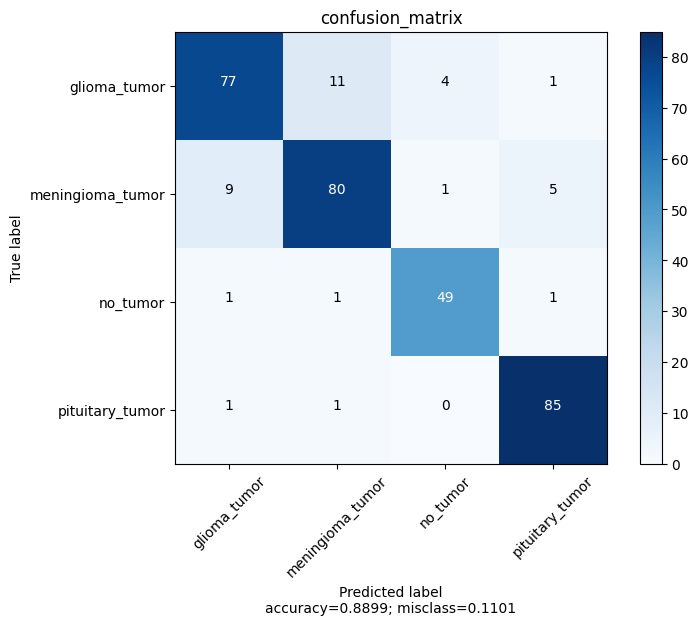

In [21]:
cf_matrix_vgg = confusion_matrix(y_test,y_pred_vgg)
plot_confusion_matrix(cf_matrix_vgg, labels, "confusion_matrix", normalize=False)

### Let's take a look at some predicted images and compare it with their actual labales 

Source: https://www.kaggle.com/code/satishgunjal/neural-network-model-to-classify-images

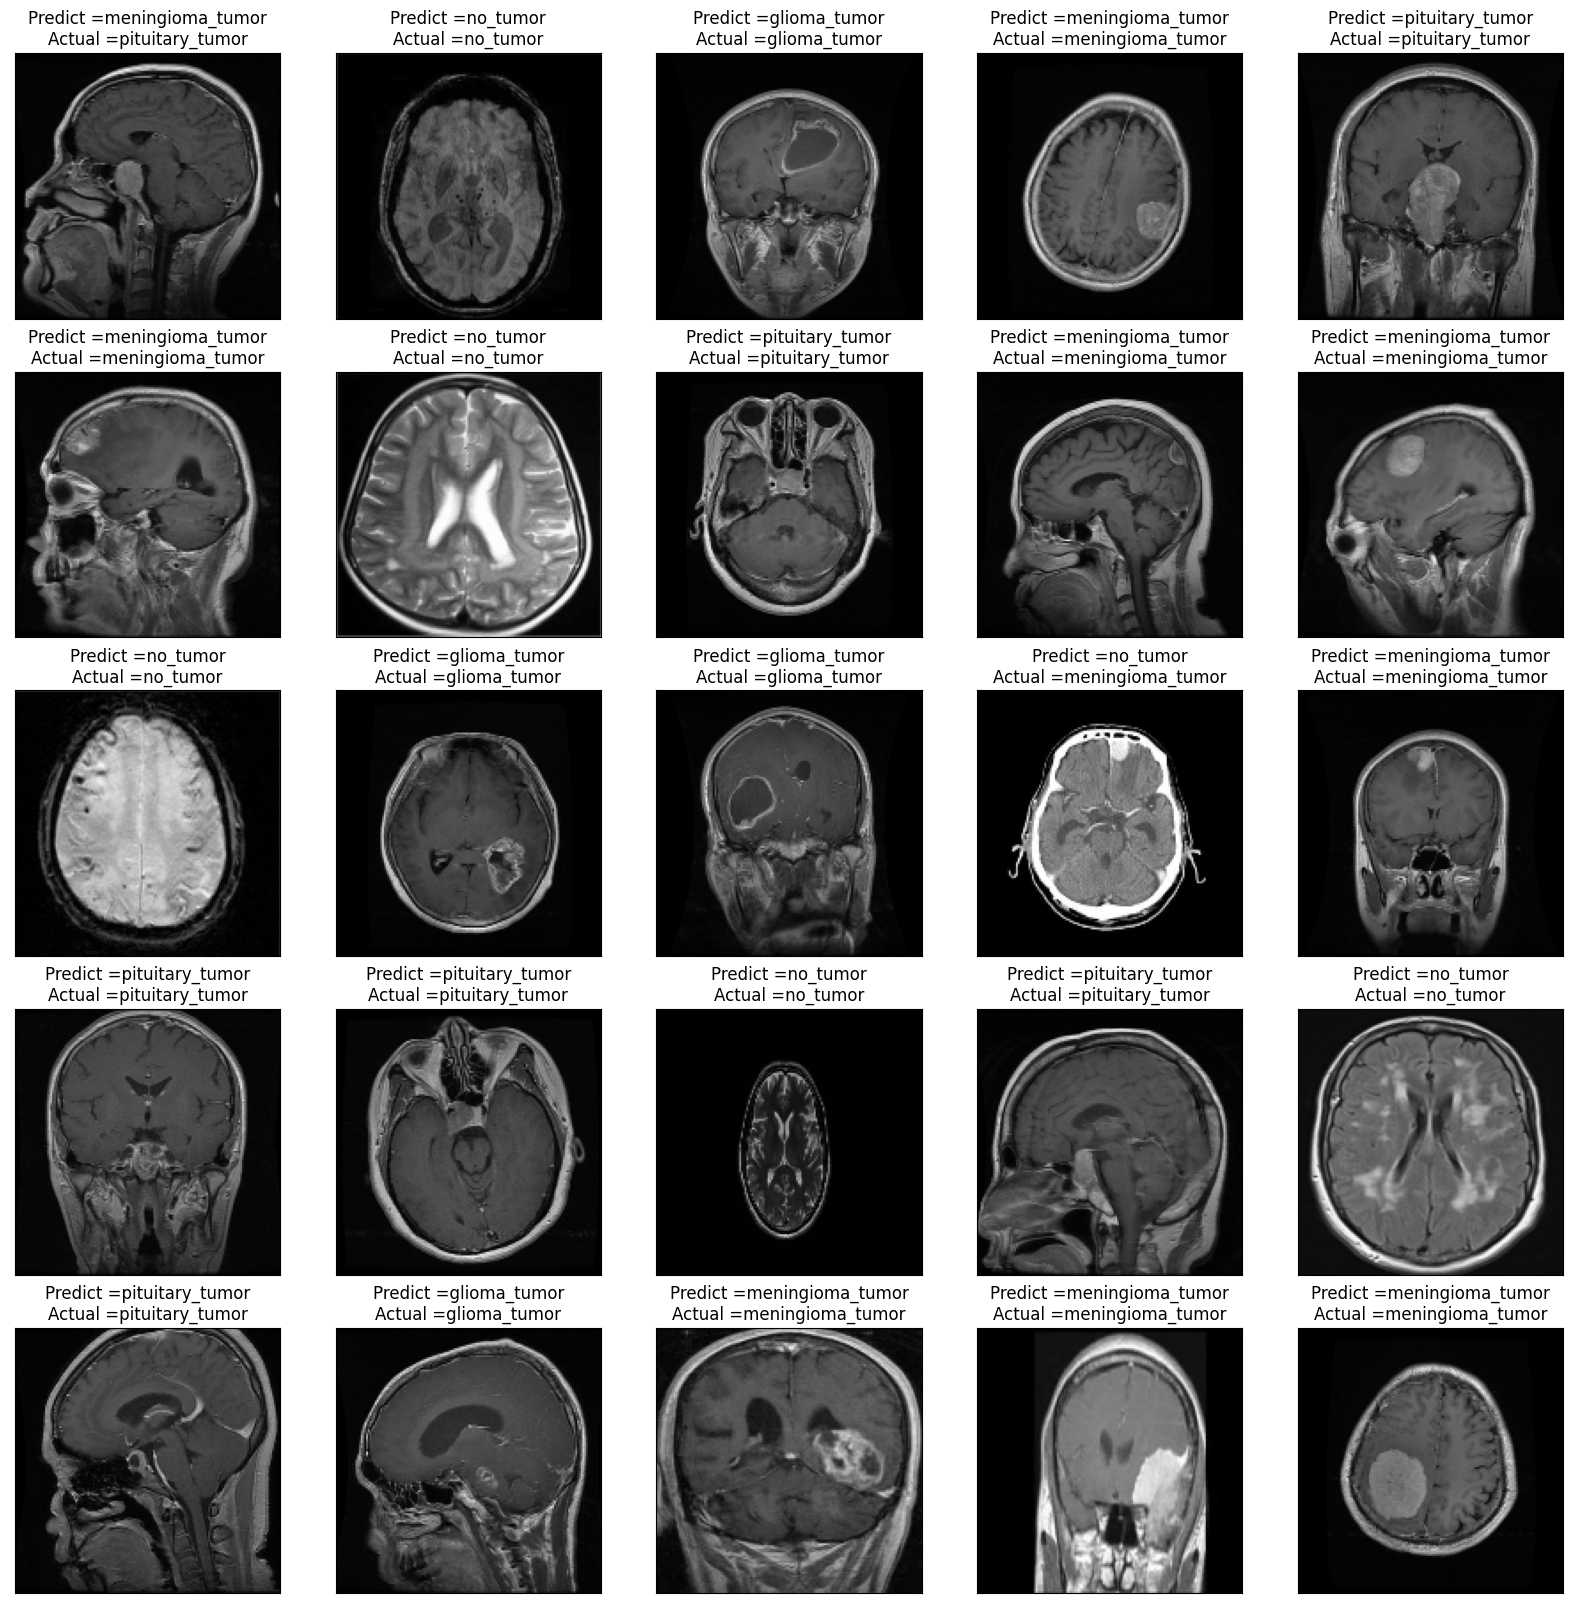

In [108]:
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)
    plt.title('Predict ='+get_stringlabel(y_pred_vgg[i]) +'\nActual ='+get_stringlabel(y_test[i]))
plt.show()

# Building the CNN model

Quelle1: https://www.tensorflow.org/tutorials/images/cnn

Quelle2: https://www.kaggle.com/code/amay09/brain-tumor-detection-using-cnn

In [ ]:
'''image_size = 150
cnn_model = keras.models.Sequential([
        keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu',input_shape=(image_size,image_size,3)),
        keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
        keras.layers.MaxPool2D(4,4),
        keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),    
        keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu'),    
        keras.layers.Conv2D(16,kernel_size=(3,3),activation='relu'),
        keras.layers.MaxPool2D(4,4),
        keras.layers.Flatten() ,    
        keras.layers.Dense(64,activation='relu') ,    
        keras.layers.Dense(32,activation='relu') ,    
        keras.layers.Dense(32,activation='relu') ,        
        keras.layers.Dropout(rate=0.5) ,            
        keras.layers.Dense(4,activation='softmax') ,    
        ])
cnn_model.compile(optimizer ='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])'''

### How doese the black-box model look like?

In [ ]:
'''print('Model Details are : ')
print(cnn_model.summary())'''

Model Details are : 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 128)     147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        73792     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 16)        4624      
                                   

### Fitting the CNN model

In [ ]:
'''epochs = 10
ThisModel = cnn_model.fit(X_train, y_train, epochs=epochs, batch_size=64,verbose=1)'''

### Saving the model

In [ ]:
'''cnn_model.save('tumor-classifier.h5')'''

### Loading the saved Model

In [22]:
cnn_model = keras.models.load_model('tumor-classifier.h5')

### Let's now gernerate predictions 

In [23]:
y_pred_cnn = cnn_model.predict(X_test)
y_pred_cnn= y_pred_cnn.argmax(axis=1)

print('Prediction Shape is ', y_pred_cnn.shape)

11/11 [==============================] - 2s 138ms/step
Prediction Shape is  (327,)


### Let's evaluate the cnn model

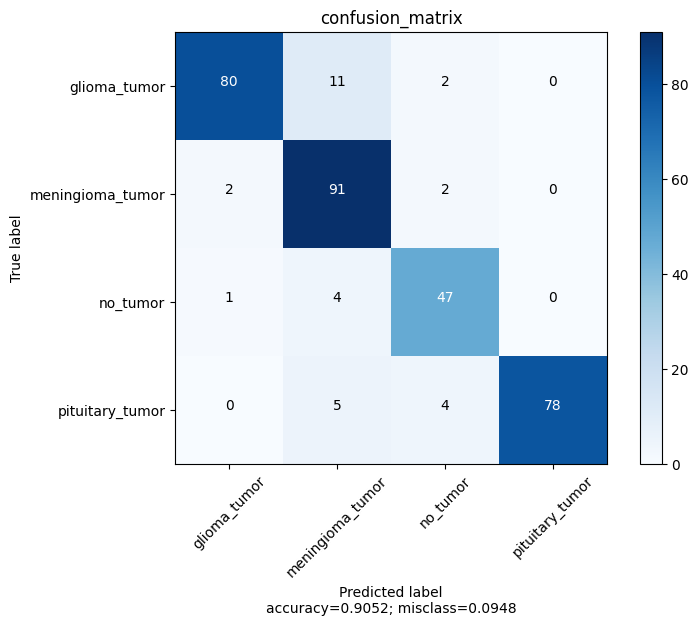

In [24]:
cf_matrix_cnn = confusion_matrix(y_test,y_pred_cnn)
plot_confusion_matrix(cf_matrix_cnn, labels, "confusion_matrix", normalize=False)

### Let's take a look at some predicted images and compare it with their actual labales 

Source: https://www.kaggle.com/code/satishgunjal/neural-network-model-to-classify-images

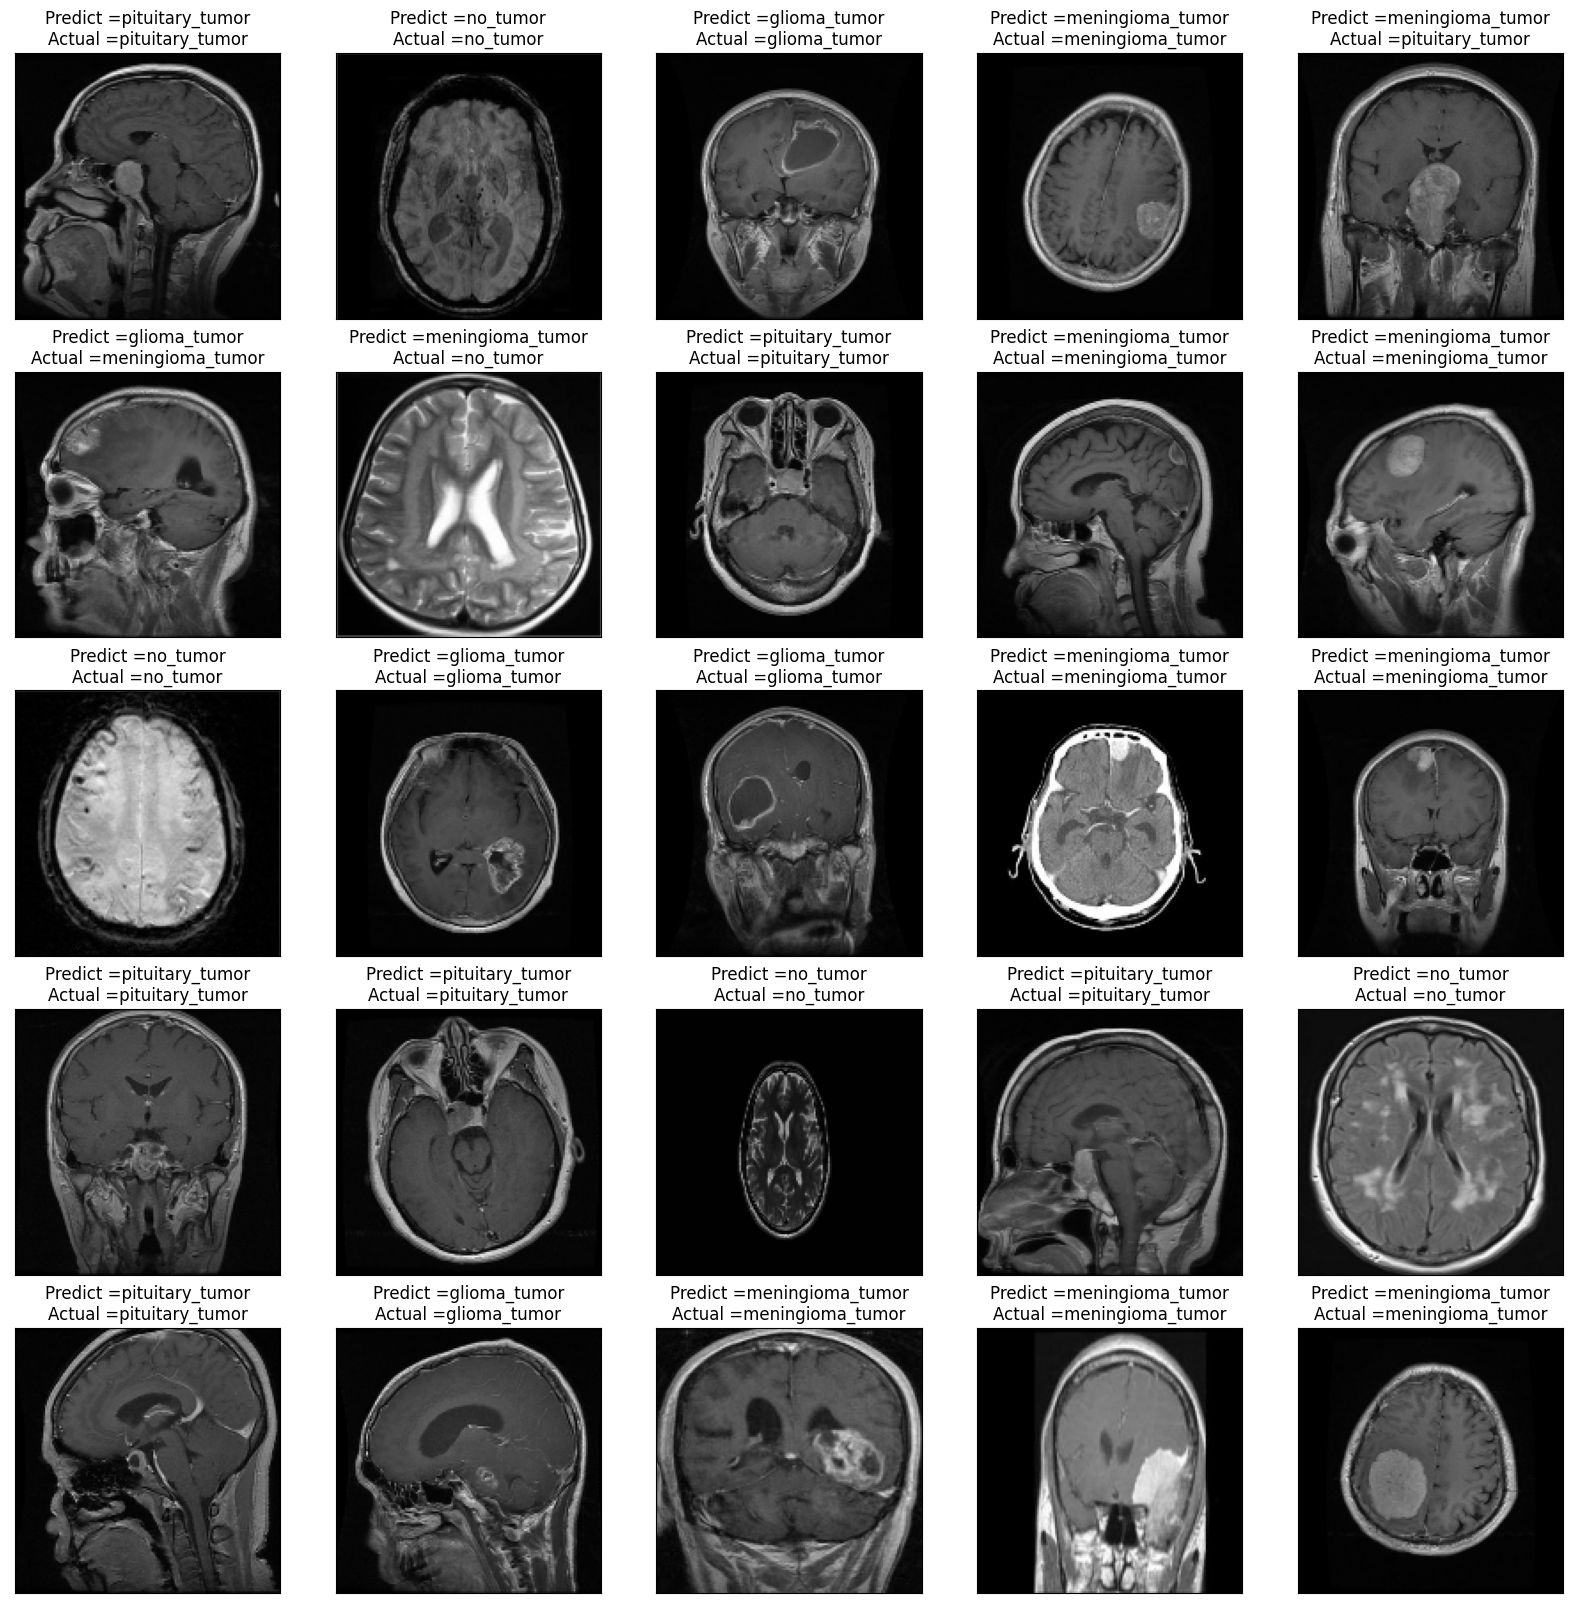

In [107]:
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)
    plt.title('Predict ='+get_stringlabel(y_pred_cnn[i]) +'\nActual ='+get_stringlabel(y_test[i]))
plt.show()

# Explain the Blackbox models with LIME and SHAP

### Let's get the indices of the correct and incorrect labelled Images from the CNN-Model

In [33]:
right_cnn = get_correct_classified_imgs(y_pred_cnn)
wrong_cnn = get_incorrect_classified_imgs(y_pred_cnn)

In [34]:
print(f'we have {len(right_cnn)} right classified images and {len(wrong_cnn)} wrong classified images')

we have 296 right classified images and 31 wrong classified images


### Let's get the indices of the correct and incorrect labelled Images from the VGG-Model

In [37]:
right_vgg = get_correct_classified_imgs(y_pred_vgg)
wrong_vgg = get_incorrect_classified_imgs(y_pred_vgg)

In [77]:
print(f'we have {len(right_vgg)} right classified images and {len(wrong_vgg)} wrong classified images')

we have 291 right classified images and 36 wrong classified images


### Let's define how many images we want to explain

In [26]:
n = 2

## Explaining Black-Box Models with LIME

Quelle1: https://towardsdatascience.com/how-to-explain-image-classifiers-using-lime-e364097335b4

Quelle2 = https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20images.html


### At First we need to define our explainer for the Blackbox models

In [25]:
LIMEEXPL_CNN = lime_image.LimeImageExplainer(random_state=123)

In [32]:
LIMEEXPL_VGG = lime_image.LimeImageExplainer(random_state=123)

### Explaining the incorrect labelled images from the CNN-Model

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


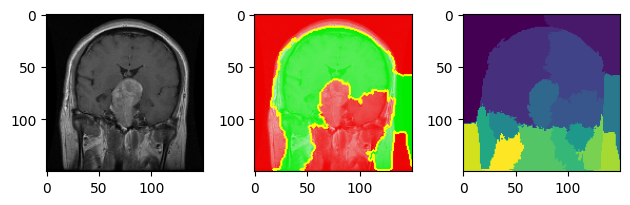

Correct Label: pituitary_tumor
Predicted Label: meningioma_tumor


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


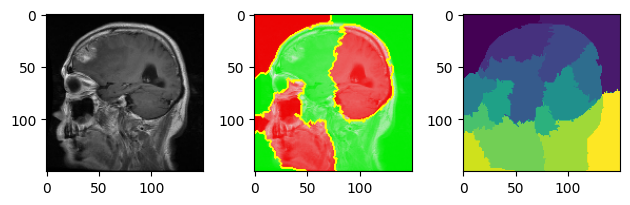

Correct Label: meningioma_tumor
Predicted Label: glioma_tumor


In [96]:
for i in range(n): 
    genereate_explination_lime(LIMEEXPL_CNN, X_test[wrong_cnn[i]], cnn_model, wrong_cnn[i], y_pred_cnn)

### Explaing correct labelled Images from the CNN-Model

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 64ms/step


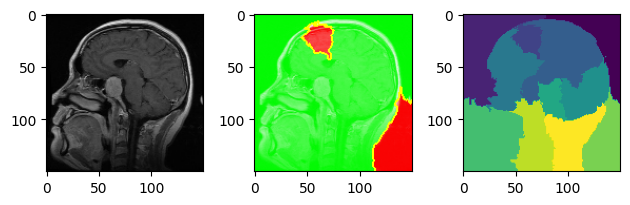

Correct Label: pituitary_tumor
Predicted Label: pituitary_tumor


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


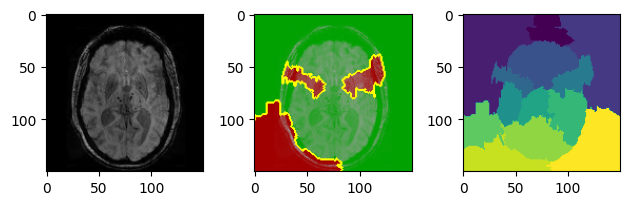

Correct Label: no_tumor
Predicted Label: no_tumor


In [97]:
for i in range(n): 
    genereate_explination_lime(LIMEEXPL_CNN, X_test[right_cnn[i]], cnn_model, right_cnn[i], y_pred_cnn)

### Explaining incorrect labelled images from the VGG-Model

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 737ms/step


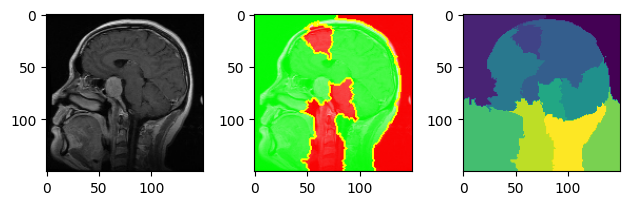

Correct Label: pituitary_tumor
Predicted Label: meningioma_tumor


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 770ms/step


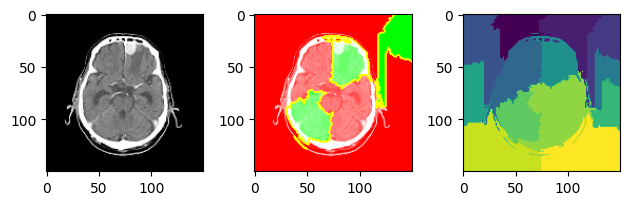

Correct Label: meningioma_tumor
Predicted Label: no_tumor


In [37]:
for i in range(n): 
    genereate_explination_lime(LIMEEXPL_VGG, X_test[wrong_vgg[i]], vgg_model, wrong_vgg[i], y_pred_vgg)

### LIME: Explaining correct labelled images from the VGG-Model

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 751ms/step


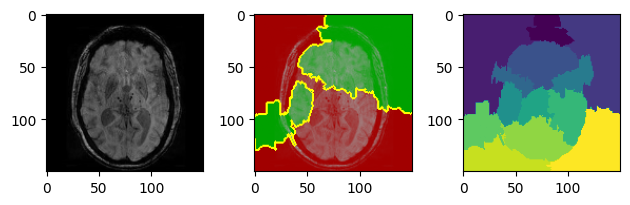

Correct Label: no_tumor
Predicted Label: no_tumor


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 686ms/step


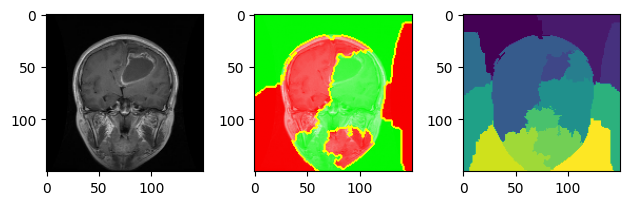

Correct Label: glioma_tumor
Predicted Label: glioma_tumor


In [39]:
for i in range(n): 
    genereate_explination_lime(LIMEEXPL_VGG, X_test[right_vgg[i]], vgg_model, right_vgg[i], y_pred_vgg)

# Explaining Black-Box Models with SHAP

Quelle: https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20ResNet50%20using%20the%20Partition%20explainer.html

### At First we need to define the masker that used to mask out partitions of the input image. This helps us to calculate the shaply values

In [28]:
masker = shap.maskers.Image("inpaint_telea", X_test[0].shape)

### Then we need to define the expaliner for the Blackbox models

In [29]:
SHAPEXPL_CNN = shap.Explainer(cnn_model, masker, output_names=labels)

In [30]:
SHAPEXPL_VGG = shap.Explainer(vgg_model, masker, output_names=labels)

### Explaining incorrect labeled images from CNN-Model

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:12, 12.22s/it]               


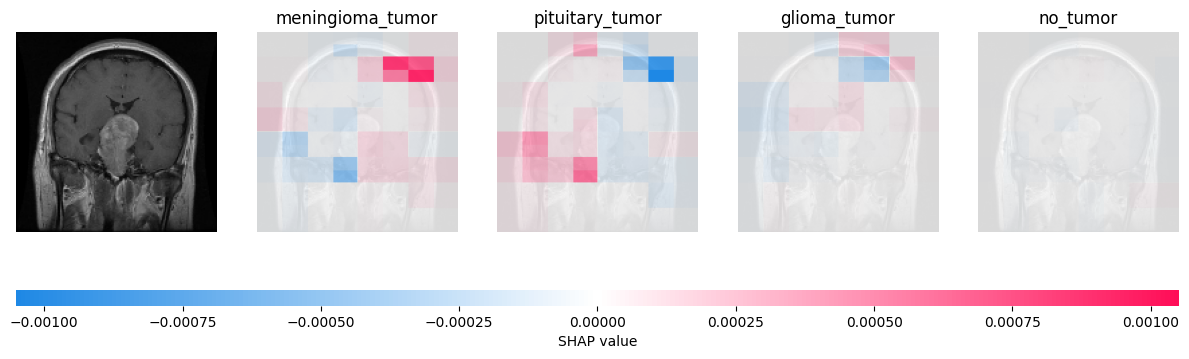

Correct Label: pituitary_tumor
Predicted Label: meningioma_tumor


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:10, 10.54s/it]               


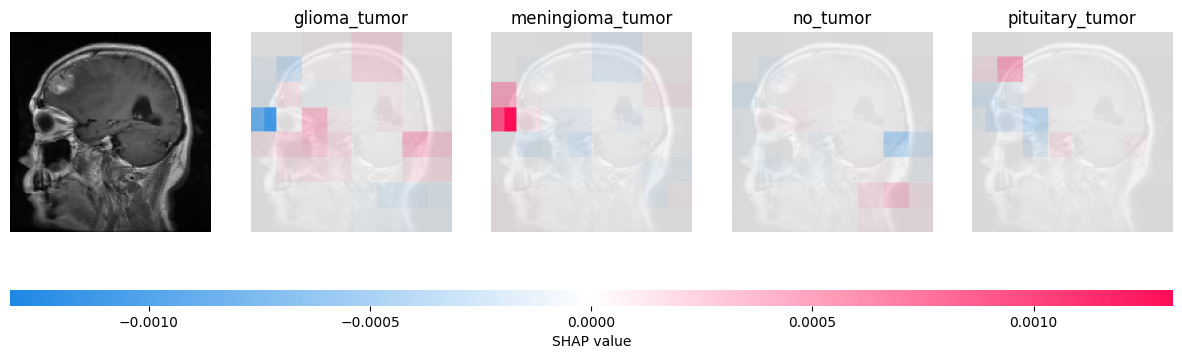

Correct Label: meningioma_tumor
Predicted Label: glioma_tumor


In [38]:
for i in range(n): 
    genereate_explination_shap(SHAPEXPL_CNN, wrong_cnn[i], y_pred_cnn)

### Explaining correct labeled images from CNN-Model

  0%|          | 0/498 [00:00<?, ?it/s]

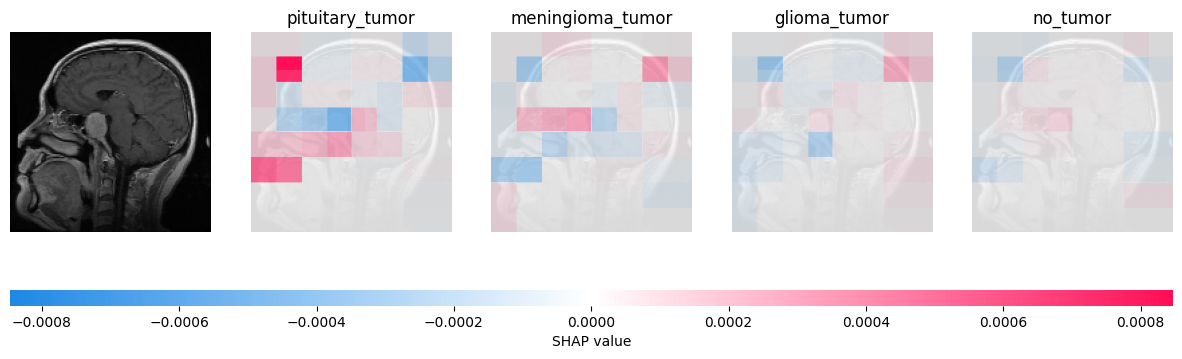

Correct Label: pituitary_tumor
Predicted Label: pituitary_tumor


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:11, 11.26s/it]               


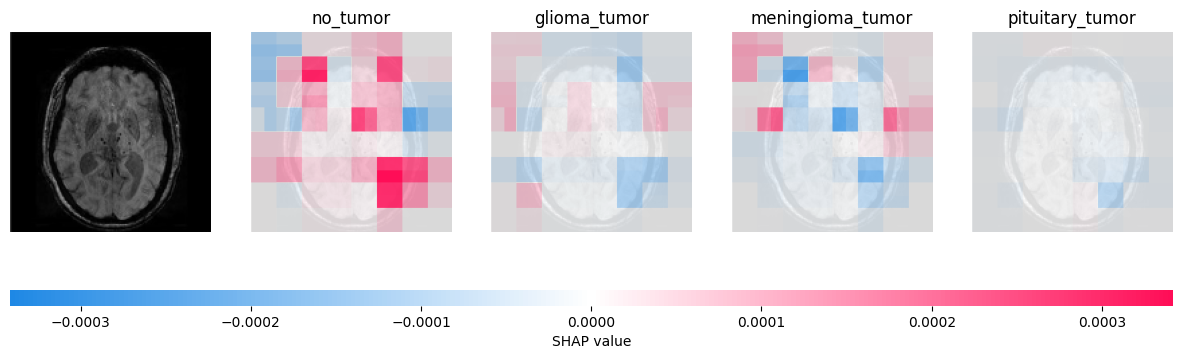

Correct Label: no_tumor
Predicted Label: no_tumor


In [49]:
for i in range(n): 
    genereate_explination_shap(SHAPEXPL_CNN, right_cnn[i], y_pred_cnn)

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [01:04, 64.15s/it]               


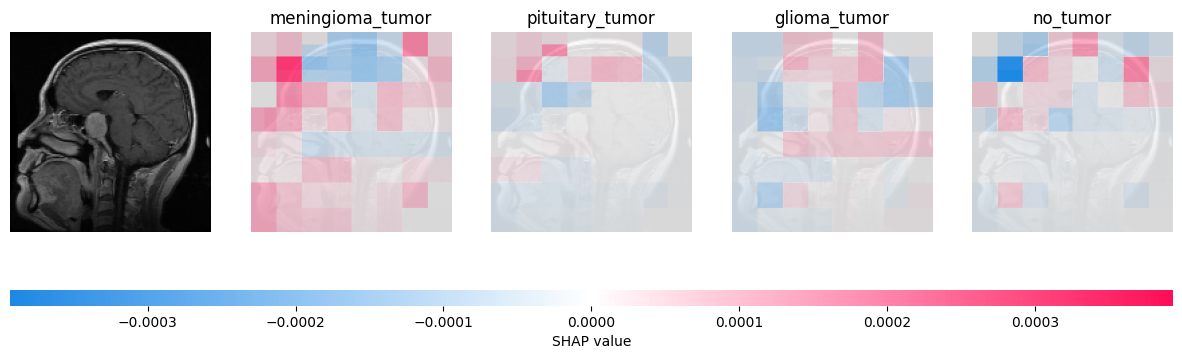

Correct Label: pituitary_tumor
Predicted Label: meningioma_tumor


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:55, 55.64s/it]               


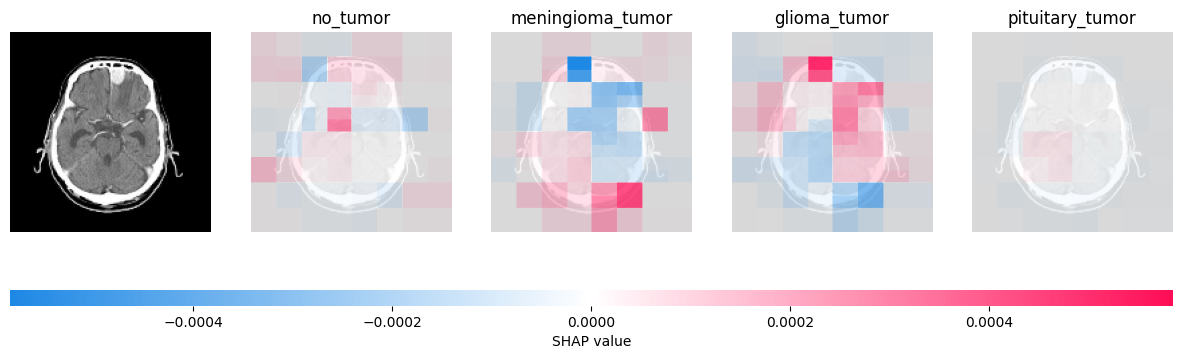

Correct Label: meningioma_tumor
Predicted Label: no_tumor


In [39]:
for i in range(n): 
    genereate_explination_shap(SHAPEXPL_VGG, wrong_vgg[i], y_pred_vgg)

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:56, 56.53s/it]               


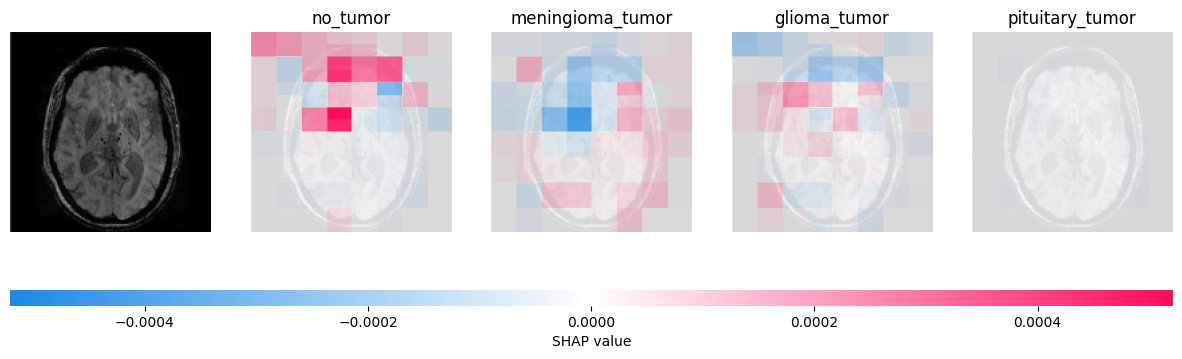

Correct Label: no_tumor
Predicted Label: no_tumor


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [01:02, 62.39s/it]               


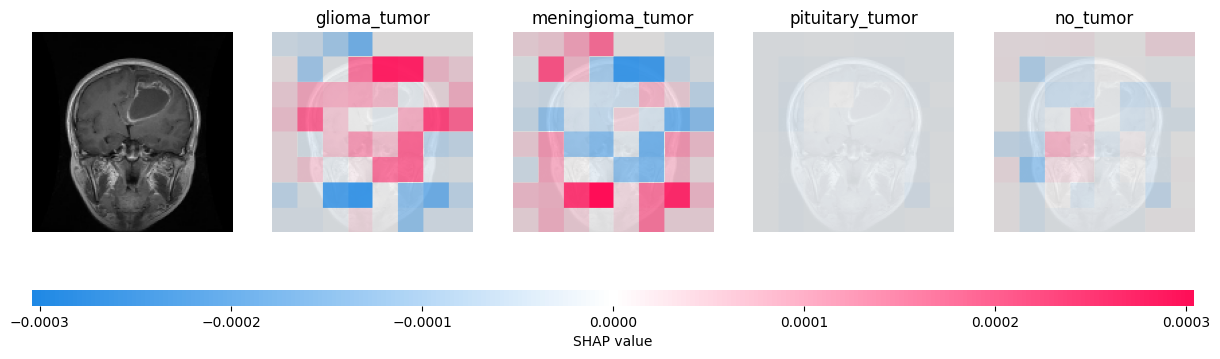

Correct Label: glioma_tumor
Predicted Label: glioma_tumor


In [40]:
for i in range(n): 
    genereate_explination_shap(SHAPEXPL_VGG, right_vgg[i], y_pred_vgg)